In [1]:
from __future__ import division
import pandas as pd
import numpy as np
from scipy.signal import medfilt, butter, filtfilt, lfilter, find_peaks, find_peaks_cwt,resample, detrend
# wwelches test
from scipy.signal import welch, spectrogram, get_window
import urllib.parse
import logging
import math
import time
import statistics as stats
import json
from datetime import datetime, timedelta
import os, sys
import matplotlib.pyplot as plt
import glob

### Data

1. A single file represents an assessment data capture that contains 5 reps of flexion extension
2. the file is named <vag_oa_assessment_patient_name>

The data contains x,y,z acceleration at a sampling rate of 6Khz (logger)
6000 hz over 5 reps of approximately 4 seconds per rep is 20 seconds total = 120000 samples 
6000 hz over 6 reps of approximately 2 seconds per rep is 12 seconds total = 72000 samples

### Protocol

1. seated flexion / extension of single limb
2. 5 times (reps) where each rep (up / down) is approximately 4 seconds
3. 2 seconds up and 2 seconds down supported by a metronome

https://www.musicca.com/metronome (30 beats per minute is 1 sound every 2 seconds)

In [6]:
# functions
# pass in 3 axis as a []
def vector_magnitude(vectors):
    n = len(vectors[0])
    assert all(len(v) == n for v in vectors), "Vectors have different lengths"
    vm = np.sqrt(sum(v ** 2 for v in vectors))
    return vm

def build_filter(frequency, sample_rate, filter_type, filter_order):
    #nyq = 0.5 * sample_rate
    if filter_type == "bandpass":
        #nyq_cutoff = (frequency[0] / nyq, frequency[1] / nyq)
        b, a = butter(filter_order, (frequency[0], frequency[1]), btype=filter_type, analog=False, output='ba', fs=sample_rate)
    elif filter_type == "low":
        #nyq_cutoff = frequency[1] / nyq
        b, a = butter(filter_order, frequency[1] / ny, btype=filter_type, analog=False, output='ba', fs=sample_rate)
    elif filter_type == "high":
        #nyq_cutoff = frequency[0] / nyq
        b, a = butter(filter_order, frequency[0], btype=filter_type, analog=False, output='ba', fs=sample_rate)
    else:
        nyq_cutoff = frequency / nyq
    return b, a
                 
def filter_signal(b, a, signal, filter):
    if(filter=="lfilter"):
        return lfilter(b, a, signal)
    elif(filter=="filtfilt"):
        return filtfilt(b, a, signal)
    elif(filter=="sos"):
        return sosfiltfilt(sos, signal)
    
def compute_fft_mag(data):
    fftpoints = int(math.pow(2, math.ceil(math.log2(len(data)))))
    print(f"computing fft with {fftpoints} points")
    fft = np.fft.fft(data, n=fftpoints)
    mag = np.abs(fft) #/ (fftpoints/2)
    return mag

# assumes a numpy arrray
def compute_power_spectrum(fft_mag):
    power = np.square(fft_mag)
    return power

def fft_graph_values(data, sample_rate):
    T = 1/sample_rate
    N_r =len(data)//2
    x = np.linspace(0.0, 1.0/(2.0*T), len(data)//2).tolist()
    y = data[:N_r]
    return [x,y]

In [7]:
# data path to patient assessment
#data_path = "data/mc_vag_test_1.csv"  # patella / 30 BPM
#data_path = "data/mc_test_2_60bpm.csv"
data_path = "data/mc_test_3_ml_60bpm.csv"

assessment_df = pd.read_csv(data_path)

In [8]:
# extract into x y z
accel_x = assessment_df['x']
print(f"length of accel x is {len(accel_x)}")
accel_y = assessment_df['y']
print(f"length of accel y is {len(accel_y)}")
accel_z = assessment_df['z']
print(f"length of accel z is {len(accel_z)}")
a_mag = assessment_df['mag']
print(f"length of mag is {len(a_mag)}")

length of accel x is 69661
length of accel y is 69661
length of accel z is 69661
length of mag is 69661


In [9]:
#filter parameters
low_cut_off = 100  # removes muscle artifacts and baseline wander
high_cut_off = 1000
filter_order = 9   # 9th order has been used in literature?
filter_type =  "bandpass"  #"bandpass"
sampling_rate = 6000

In [10]:
# consider the magnitude vector first
b,a = build_filter((low_cut_off, high_cut_off), sampling_rate, filter_type, filter_order)
f_a_mag = filter_signal(b,a, a_mag, "filtfilt")

fft_mag = compute_fft_mag(f_a_mag)
fft_graph = fft_graph_values(fft_mag, sampling_rate)
f_power = compute_power_spectrum(fft_graph[1])

# compute the total power in the signal
total_power =  round(np.sum(f_power),2)
print(f"total power: {total_power}")

computing fft with 131072 points
total power: 185509.85


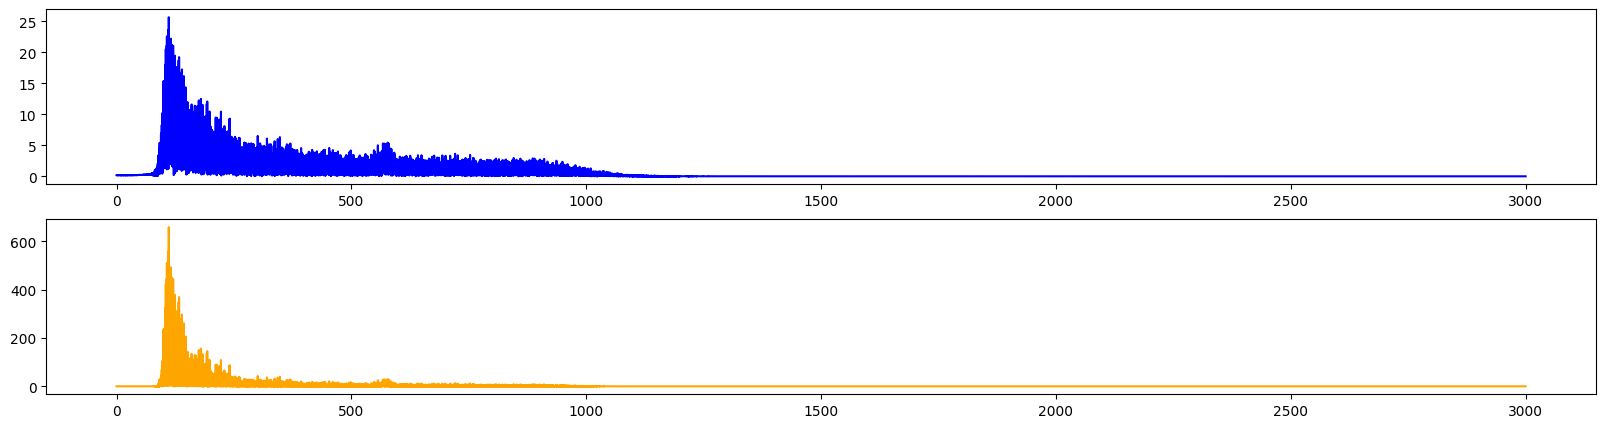

In [11]:
#plot fft
fig, ax = plt.subplots(2,1, figsize=(20, 5))

#ax[1].plot(fft_freq, fft, linewidth=2, color="black", label="Frequency Response")
ax[0].plot(fft_graph[0], fft_graph[1], color="blue")
ax[1].plot(fft_graph[0], f_power, color="orange")

In [15]:
fft_freq = np.array(fft_graph[0])
# creates 50 hz bands which could be too small
f_bands = [(f, f + 50) for f in range(100, 1000, 50)]
band_powers = []

interval_axis = []
for (low, high) in f_bands:
    interval_axis.append(f"{low}-{high}")
    band_power = np.sum(f_power[(fft_freq >= low) & (fft_freq < high)])
    band_powers.append(band_power)

# computes the percentage contribution of each frequency band
band_percentages = [(bp / total_power) * 100 for bp in band_powers]

Text(0, 0.5, '% power [a*2/Hz]')

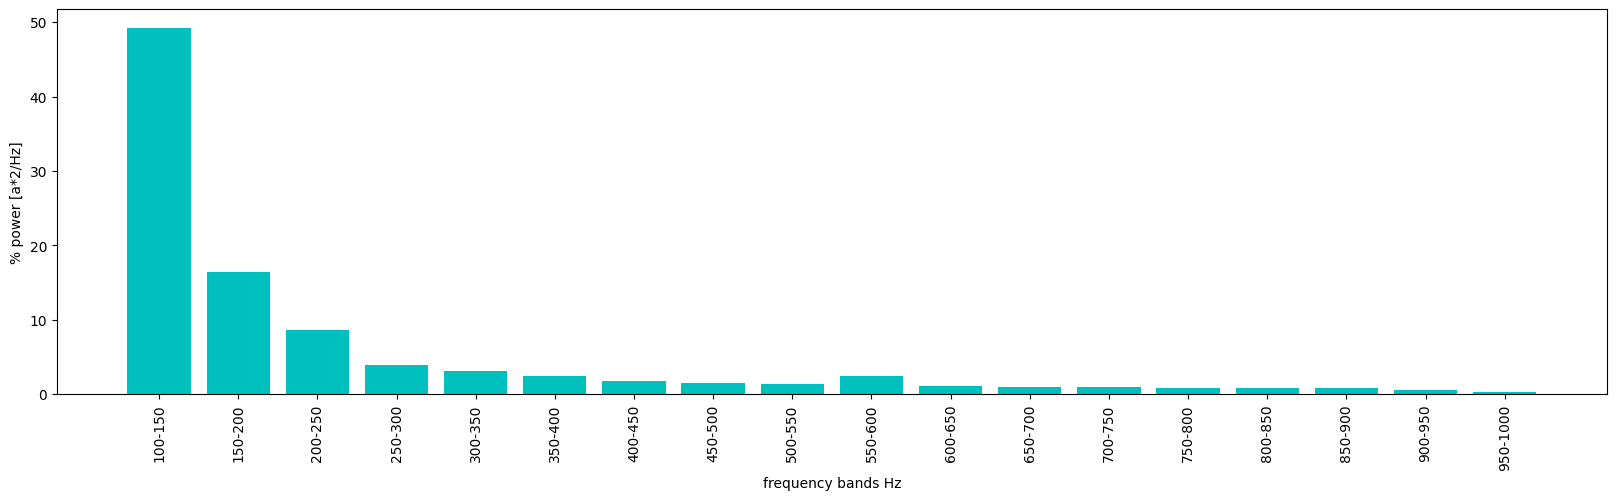

In [16]:
# plot the band percentages as bar chart
fig, ax = plt.subplots(1,1, figsize=(20, 5))
# Plot the bar chart
ax.bar(interval_axis, band_percentages, color="c")
ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel("frequency bands Hz")
ax.set_ylabel("% power [a*2/Hz]")

Text(0, 0.5, 'frequency')

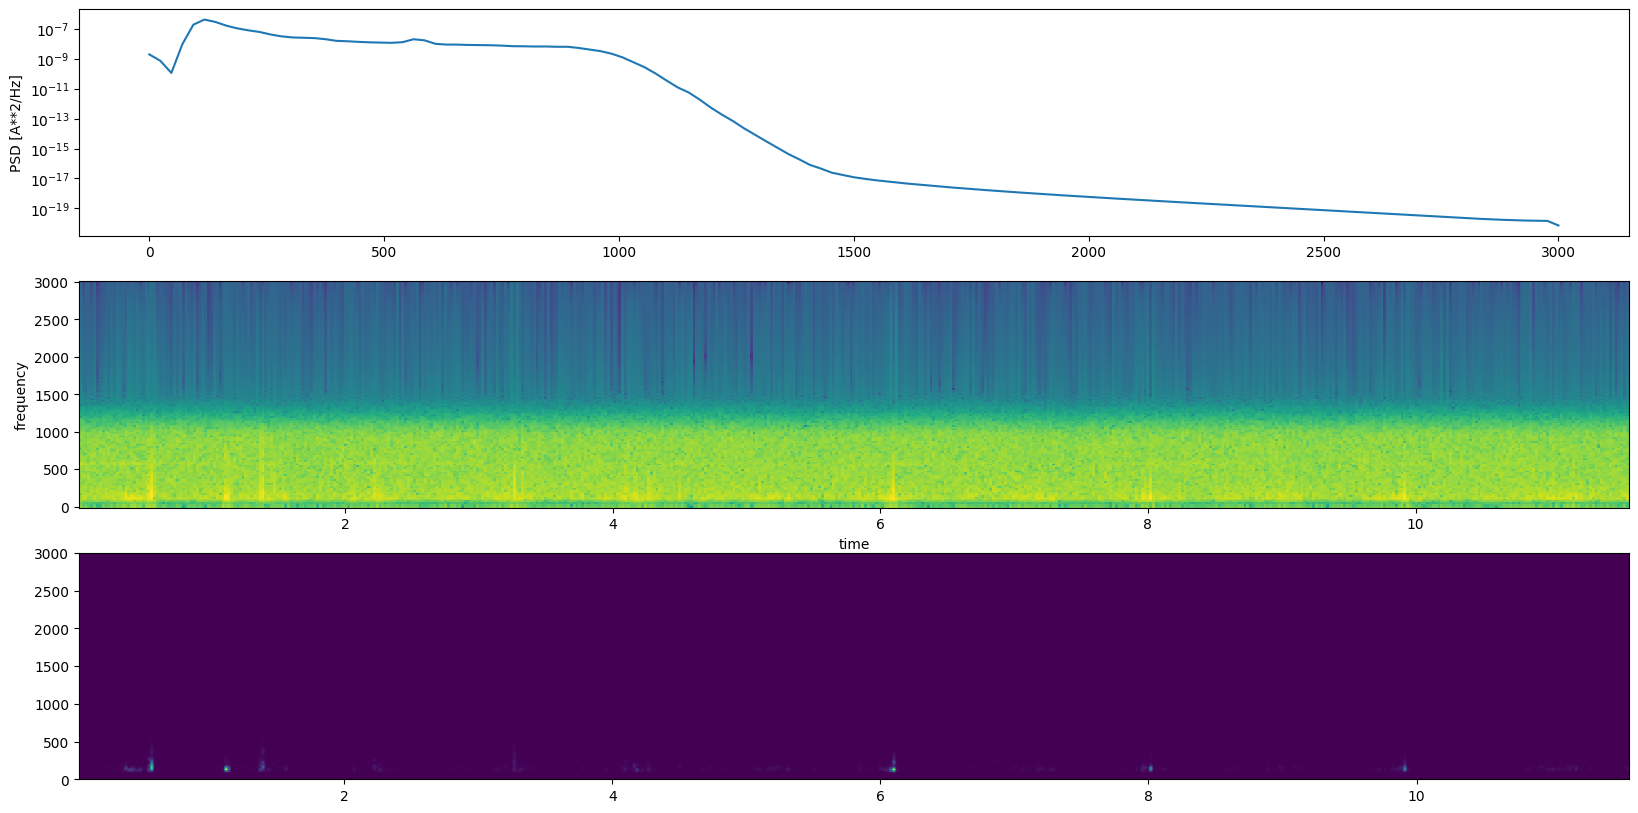

In [17]:
segment_length = 256  # Length of each segment
overlap = segment_length // 2  # 50% overlap
window = get_window('hann', segment_length)  # Hann window

# Compute the power spectral density
f_welch, psd = welch(f_a_mag, fs=sampling_rate, window=window, nperseg=segment_length, noverlap=overlap, scaling='density')

# scaling="density" scaling="spectrum"
frequencies, times, Sxx = spectrogram(f_a_mag, fs=sampling_rate, window=window, nperseg=segment_length, noverlap=overlap, scaling='density')

fig, ax = plt.subplots(3,1, figsize=(20, 10))
ax[0].semilogy(f_welch, psd)
ax[1].pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='auto')
ax[2].imshow(Sxx, aspect='auto', cmap='viridis', origin='lower', extent=[times.min(), times.max(), frequencies.min(), frequencies.max()])

ax[0].set_ylabel('PSD [A**2/Hz]')
ax[1].set_xlabel("time")
ax[1].set_ylabel("frequency")